In [ ]:
load("chapter8_TreeBasedMethods.RData")

In [1]:
library(tree)
library(randomForest)
library(gbm)
library(pROC)
library(DMwR2)
library(mlbench)
library(MASS)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.

Loaded gbm 2.1.8.1

Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



# 1. For Classification

## 1.1 Process data
Although tree model can handle missing values without explict processing steps, it's still important to be mindful of the potential implications and consider the impact of missingness on the model's performance, interpretation, and any downstream analysis. So, we impute missing values in this example. 

For binary classification, we can use either numeric or factor. 
We use factor y in decision tree/ bagging/ random forests as numberic y will be treated as regression task.
We use numeric y in gbm as factor type of y will return NAs' cofficient.

In [2]:
data("PimaIndiansDiabetes2")
cdata <- PimaIndiansDiabetes2
head(cdata)

cat("Sum of NAs in cdata is", sum(is.na(cdata)))
manyNAs(t(cdata), nORp = 0.1)
cdata <- cdata[, -manyNAs(t(cdata), nORp = 0.1)]
dim(cdata)
cdata <- knnImputation(data = cdata, k = 10, scale = T, meth = "weighAvg", distData = NULL)
cat("Sum of NAs in imputed cdata", sum(is.na(cdata)))
cdata$diabetes <- as.numeric(cdata$diabetes)
head(cdata, n = c(2, 7))
cdata <- transform(cdata, diabetes = diabetes -1)
cdata$diabetes <- factor(cdata$diabetes)
head(cdata)
set.seed(0)
ctrain <- sample(1: nrow(cdata), size = nrow(cdata) * 0.8)
cy.test <- cdata$diabetes[-ctrain]

,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,6,148,72,35,NA,33.6,0.627,50,pos
2,1,85,66,29,NA,26.6,0.351,31,neg
3,8,183,64,NA,NA,23.3,0.672,32,pos
4,1,89,66,23,94,28.1,0.167,21,neg
5,0,137,40,35,168,43.1,2.288,33,pos
6,5,116,74,NA,NA,25.6,0.201,30,neg


Sum of NAs in cdata is 652

triceps insulin 
      4       5

[1] 768   7

Sum of NAs in imputed cdata 0

,pregnant,glucose,pressure,mass,pedigree,age,diabetes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,6,148,72,33.6,0.627,50,2
2,1,85,66,26.6,0.351,31,1


,pregnant,glucose,pressure,mass,pedigree,age,diabetes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,6,148,72,33.6,0.627,50,1
2,1,85,66,26.6,0.351,31,0
3,8,183,64,23.3,0.672,32,1
4,1,89,66,28.1,0.167,21,0
5,0,137,40,43.1,2.288,33,1
6,5,116,74,25.6,0.201,30,0


## 1.2 Decision Tree

fitting a big decision tree in training data and predicting in testing data

Splitting continues until the terminal nodes are 
too small or too few to be split. 
Regression trees' depth is limited to 31, 
and classfication trees' is 32.


Classification tree:
tree(formula = diabetes ~ ., data = cdata, subset = ctrain)
Variables actually used in tree construction:
[1] "glucose"  "mass"     "age"      "pedigree"
Number of terminal nodes:  12 
Residual mean deviance:  0.8768 = 527.9 / 602 
Misclassification error rate: 0.2068 = 127 / 614 

The auc is 0.8649038
The accuracy is 0.7922078

             cy.test
cbigtree.pred  0  1
            0 86 14
            1 18 36

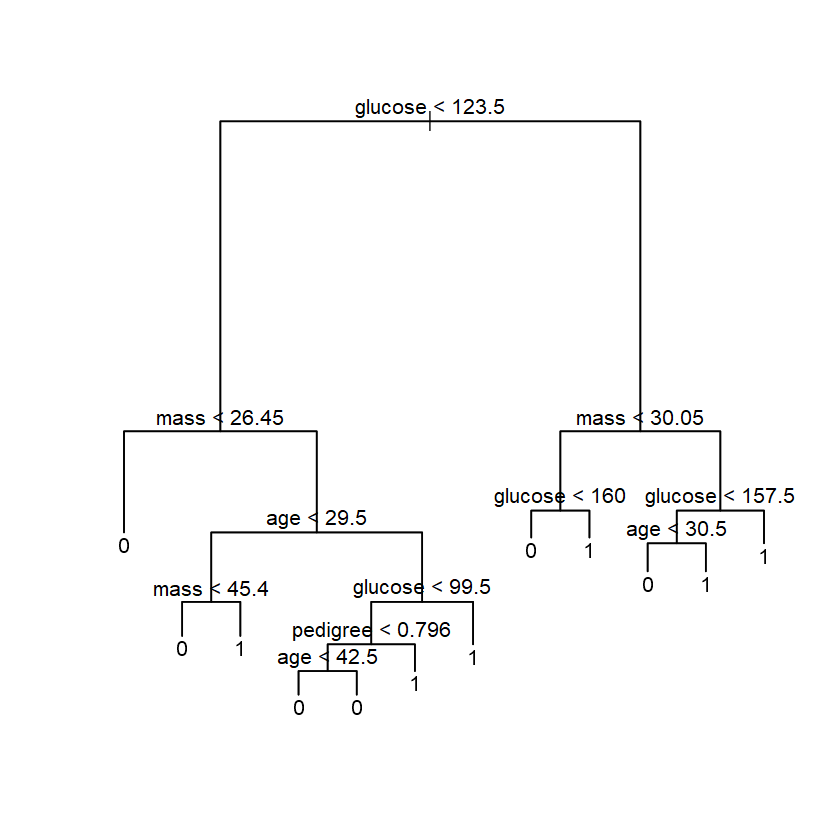

In [3]:
cbigtree <- tree(diabetes~. , data = cdata, subset = ctrain)
cat("Splitting continues until the terminal nodes are 
too small or too few to be split. 
Regression trees' depth is limited to 31, 
and classfication trees' is 32.")
summary(cbigtree)
plot(cbigtree)
text(cbigtree, pretty = 0)
cbigtree.prob <- predict(cbigtree, newdata = cdata[-ctrain, ], type = "vector")[, 2]
cat("The auc is", auc(response = cdata$diabetes[-ctrain], predictor = cbigtree.prob, levels = c(0, 1), direction = "<"))
cbigtree.pred <- predict(cbigtree, newdata = cdata[-ctrain, ], type = "class")
cat("\nThe accuracy is", sum(cbigtree.pred == cy.test) / length(cy.test))
table(cbigtree.pred, cy.test)

prune---using cross-validation to select the best $\alpha$

FUN=prune.misclass - means we want classification error rate instead of devience to select the best tree


$size
[1] 12 11  6  4  3  2  1

$dev
[1] 174 174 175 171 161 175 219

$k
[1] -Inf  0.0  1.8  3.0  5.0 24.0 47.0

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

Note: 1.k means alpha in prune loss
      2.despite the name, 'dev' correspond to the cross-validation error rate in this instance
The best size of the tree is 3

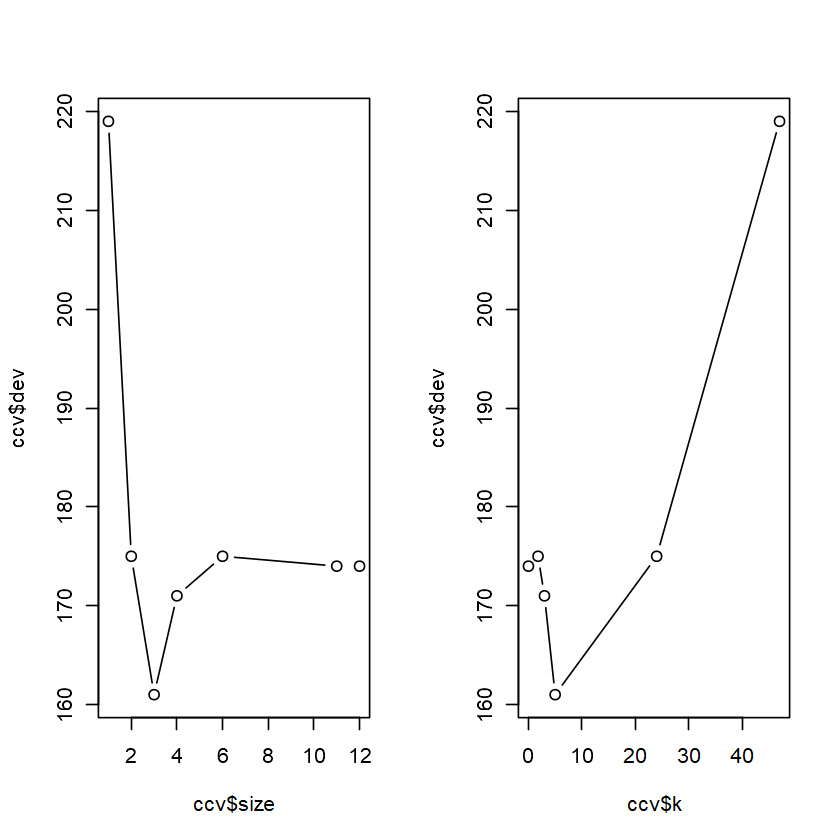

In [4]:
set.seed(1)
cat("FUN=prune.misclass - means we want classification error rate instead of devience to select the best tree
")
ccv <- cv.tree(cbigtree, FUN = prune.misclass)
ccv
cat("Note: 1.k means alpha in prune loss\n")
cat("      2.despite the name, 'dev' correspond to the cross-validation error rate in this instance\n")
cat("The best size of the tree is", ccv$size[which.min(ccv$dev)])
par(mfrow = c(1, 2))
plot(ccv$size, ccv$dev, type = "b")
plot(ccv$k, ccv$dev, type="b")

prune---getting best subtree and predicting

The auc is 0.7855769


The accuracy is 0.7922078

           cy.test
cprune.pred  0  1
          0 90 18
          1 14 32

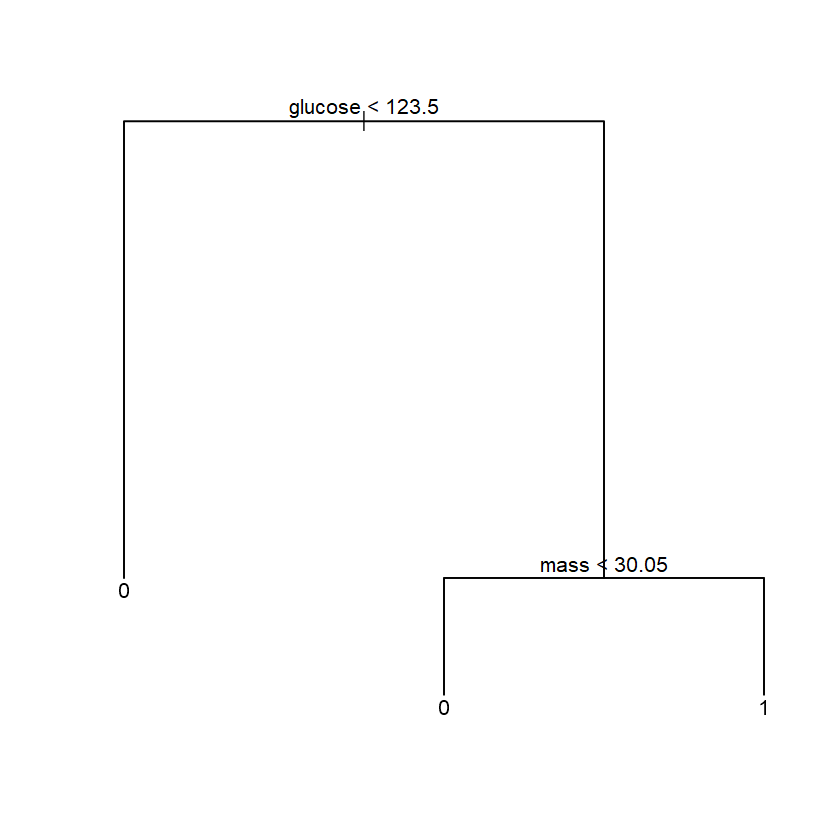

In [5]:
cprune <- prune.misclass(tree = cbigtree, best = ccv$size[which.min(ccv$dev)])
plot(cprune)
text(cprune, pretty = 0)
cprune.prob <- predict(cprune, newdata = cdata[-ctrain, ], type = "vector")[, 2]
cat("The auc is", auc(response = cy.test, predictor = cprune.prob, levels = c(0, 1), direction = "<"))
cprune.pred <- predict(cprune, newdata = cdata[-ctrain, ], type = "class")
cat("\nThe accuracy is", sum(cprune.pred == cy.test) / length(cy.test))
table(cprune.pred, cy.test)

## 1.2 Bagging and Random Forests
By default, randomForest()
uses p/3 variables when building a random forest of regression trees, and
$\sqrt{p}$ variables when building a random forest of classification trees.

bagging


Call:
 randomForest(formula = diabetes ~ ., data = cdata, mtry = 6,      type = "classification", importance = TRUE, subset = ctrain) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 6

        OOB estimate of  error rate: 24.59%
Confusion matrix:
    0   1 class.error
0 324  72   0.1818182
1  79 139   0.3623853

The auc using 500 trees is 0.8867308
The accuracy using 500 trees is 0.8376623

         cy.test
cbag.pred  0  1
        0 96 17
        1  8 33

The auc using 50 trees is 0.8593269
The accuracy using 50 trees is 0.8116883

                 cy.test
cbag.50trees.pred  0  1
                0 95 20
                1  9 30

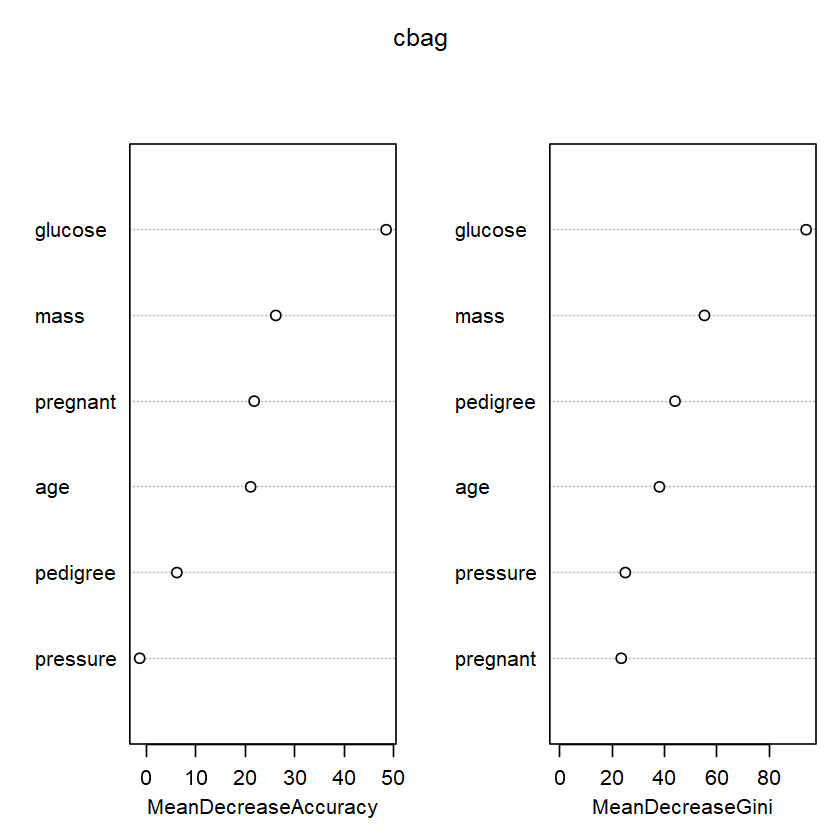

In [6]:
set.seed(0)
cbag <- randomForest(diabetes~., data = cdata, subset = ctrain, mtry = 6, type = "classification", importance = TRUE)
cbag
cbag.prob <- predict(cbag, newdata = cdata[-ctrain, ], type = "prob")[, 2] # vote
cat("The auc using 500 trees is", auc(response = cy.test, predictor = cbag.prob, levels = c(0, 1), direction = "<"))
cbag.pred <- predict(cbag, newdata = cdata[-ctrain, ], type = "response")
cat("\nThe accuracy using 500 trees is", sum(cbag.pred == cy.test) / length(cy.test))
table(cbag.pred, cy.test)
cbag.50trees <- randomForest(diabetes~., data = cdata, subset = ctrain, mtry = 6, type = "classification", importance = TRUE, ntree = 50)
cbag.50trees.prob <- predict(cbag.50trees, newdata = cdata[-ctrain, ], type = "prob")[, 2]
cat("The auc using 50 trees is", auc(response = cy.test, predictor = cbag.50trees.prob, levels = c(0, 1), direction = "<"))
cbag.50trees.pred <- predict(cbag.50trees, newdata = cdata[-ctrain, ], type = "class")
cat("\nThe accuracy using 50 trees is", sum(cbag.50trees.pred == cy.test) / length(cy.test))
table(cbag.50trees.pred, cy.test)
varImpPlot(cbag)

random forests


Call:
 randomForest(formula = diabetes ~ ., data = cdata, type = "classification",      mtry = 4, importance = TRUE, ntree = 500, subset = ctrain) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 24.76%
Confusion matrix:
    0   1 class.error
0 327  69   0.1742424
1  83 135   0.3807339

The auc using 500 trees is 0.8881731
The accuracy using 500 trees is 0.8441558

        cy.test
cff.pred  0  1
       0 97 17
       1  7 33


The auc using 50 trees is 0.8753846
The accuracy using 50 trees is 0.8181818

                cy.test
cff.50trees.pred  0  1
               0 93 17
               1 11 33

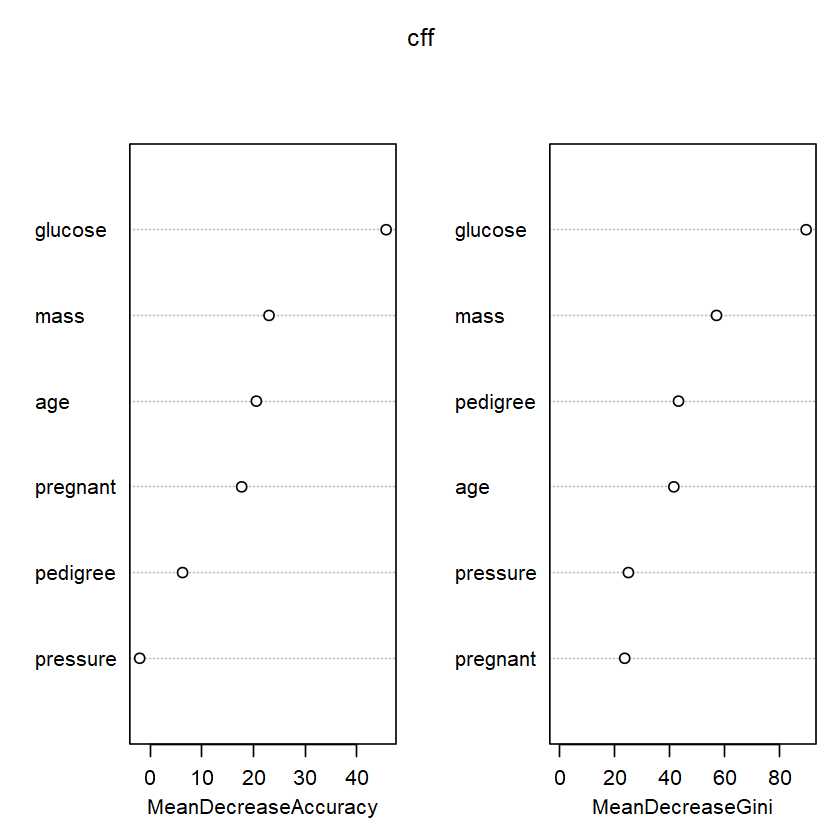

In [7]:
set.seed(0)
cff <- randomForest(diabetes~., data = cdata, subset = ctrain, type = "classification", mtry = 4, importance = TRUE, ntree = 500)
cff
cff.prob <- predict(cff, newdata = cdata[-ctrain, ], type = "prob")[, 2]
cat("The auc using 500 trees is", auc(response = cy.test, predictor = cff.prob, levels = c(0, 1), direction = "<"))
cff.pred <- predict(cff, newdata = cdata[-ctrain, ], type = "class")
cat("\nThe accuracy using 500 trees is", sum(cff.pred == cy.test) / length(cy.test))
table(cff.pred, cy.test)
cff.50trees <- randomForest(diabetes~., data = cdata[ctrain, ], type = "classification", mtry = 4, importance = TRUE, ntree = 50)
cff.50trees.prob <- predict(cff.50trees, newdata = cdata[-ctrain, ], type = "prob")[, 2]
cat("\nThe auc using 50 trees is", auc(response = cy.test, predictor = cff.50trees.prob, levels = c(0, 1), direction = "<"))
cff.50trees.pred <- predict(cff.50trees, newdata = cdata[-ctrain, ], type = "class")
cat("\nThe accuracy using 50 trees is", sum(cff.50trees.pred == cy.test) / length(cy.test))
table(cff.50trees.pred, cy.test)
varImpPlot(cff)

## 1.3 Bosting

transfer factor y to numeric y

In [8]:
cdata$diabetes <- as.numeric(cdata$diabetes)
cdata$diabetes <- cdata$diabetes - 1

In [9]:
cbost <- gbm(diabetes~., data = cdata[ctrain, ], 
    distribution = "bernoulli", n.trees = 1000, 
    interaction.depth = 4, shrinkage = 0.01)
cbost
summary(cbost, plot = FALSE)
cbost.prob <- predict(cbost, newdata = cdata[-ctrain, ], type = "response", n.trees = 1000)
# cbost.pred <- predict(cbost, newdata = cdata[-ctrain, ], type = "link")
cat("The auc is", auc(response = cy.test, predictor = cbost.prob, levels = c(0, 1), direction = "<"))
cbost.pred <- ifelse(cbost.prob >= 0.5, yes = 1, no = 0)
cat("\nThe accuracy is", sum(cbost.pred == cy.test) / length(cy.test))
table(cbost.pred, cy.test)

gbm(formula = diabetes ~ ., distribution = "bernoulli", data = cdata[ctrain, 
    ], n.trees = 1000, interaction.depth = 4, shrinkage = 0.01)
A gradient boosted model with bernoulli loss function.
1000 iterations were performed.
There were 6 predictors of which 6 had non-zero influence.

,var,rel.inf
,<chr>,<dbl>
glucose,glucose,34.846043
mass,mass,21.291370
age,age,16.092708
pedigree,pedigree,14.564658
pregnant,pregnant,7.329443
pressure,pressure,5.875778


The auc is 0.8794231
The accuracy is 0.8181818

          cy.test
cbost.pred  0  1
         0 94 18
         1 10 32

# 2. For Regression

In [10]:
dim(Boston)
set.seed(0)
rtrain <- sample(c(TRUE, FALSE), size = nrow(Boston), rep = TRUE, prob = c(0.5, 0.5))
rtest <- (!rtrain)
bos.test <- Boston[rtest, "medv"]

[1] 506  14

## 2.1 Decision Tree

Fitting big tree in training data


Regression tree:
tree(formula = medv ~ ., data = Boston[rtrain, ])
Variables actually used in tree construction:
[1] "lstat" "rm"    "nox"   "crim" 
Number of terminal nodes:  9 
Residual mean deviance:  11.15 = 2519 / 226 
Distribution of residuals:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-15.05000  -1.84700   0.07143   0.00000   1.74500   9.51900 

The deviance is simply the sum of squared errors like RSS in linear regression,
and the residual mean deviance equals MSE.
The MSE in big tree is 28.35633

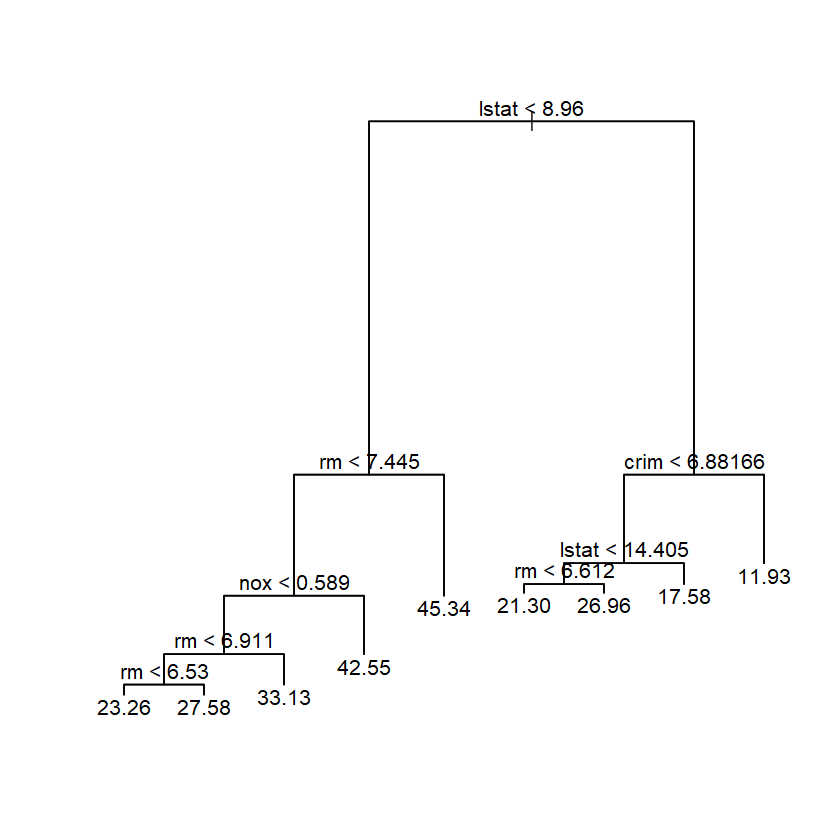

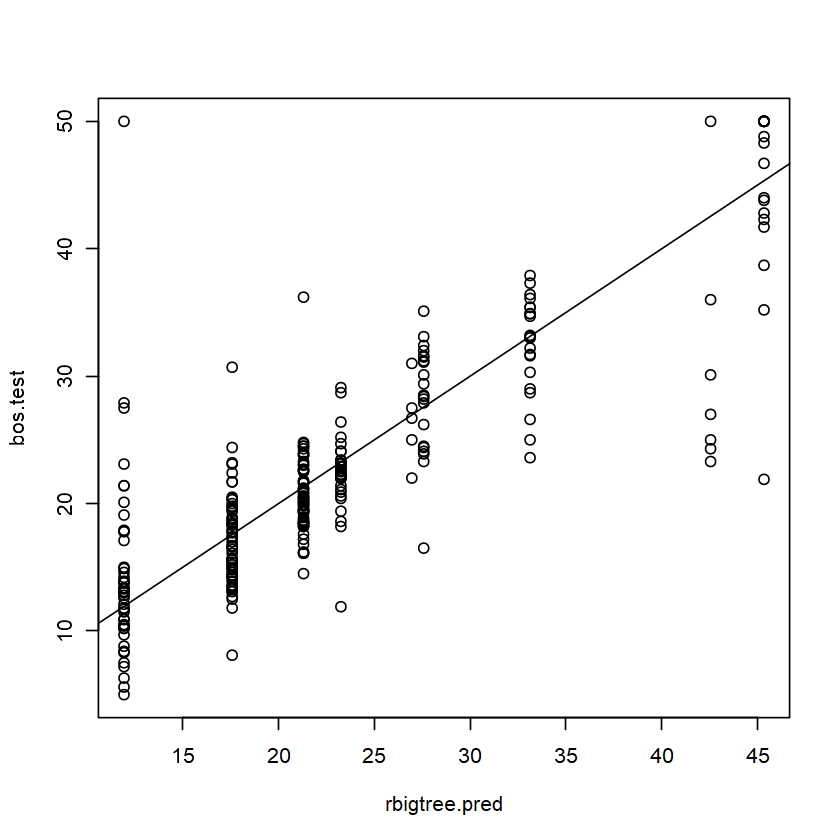

In [11]:
rbigtree.bos <- tree(medv~ ., data = Boston[rtrain, ])
summary(rbigtree.bos)
cat("The deviance is simply the sum of squared errors like RSS in linear regression,
and the residual mean deviance equals MSE.")
plot(rbigtree.bos)
text(rbigtree.bos, pretty = 0)
rbigtree.pred <- predict(rbigtree.bos, newdata = Boston[rtest, ])
cat("\nThe MSE in big tree is", mean((rbigtree.pred - bos.test)^2))
plot(rbigtree.pred, bos.test)
abline(0, 1)

prune---corss-validation to select the best subtree

$size
[1] 9 8 7 6 5 4 3 2 1

$dev
[1]  5479.385  5595.870  5665.348  5724.912  6808.813  7398.138  8377.013
[8] 11173.047 19205.978

$k
[1]      -Inf  201.6016  233.6900  483.6415  704.5917 1354.8880 2052.7743
[8] 2806.0871 8186.1790

$method
[1] "deviance"

attr(,"class")
[1] "prune"         "tree.sequence"

The size of best subtree is 9
k which means alpha in prune algorithm

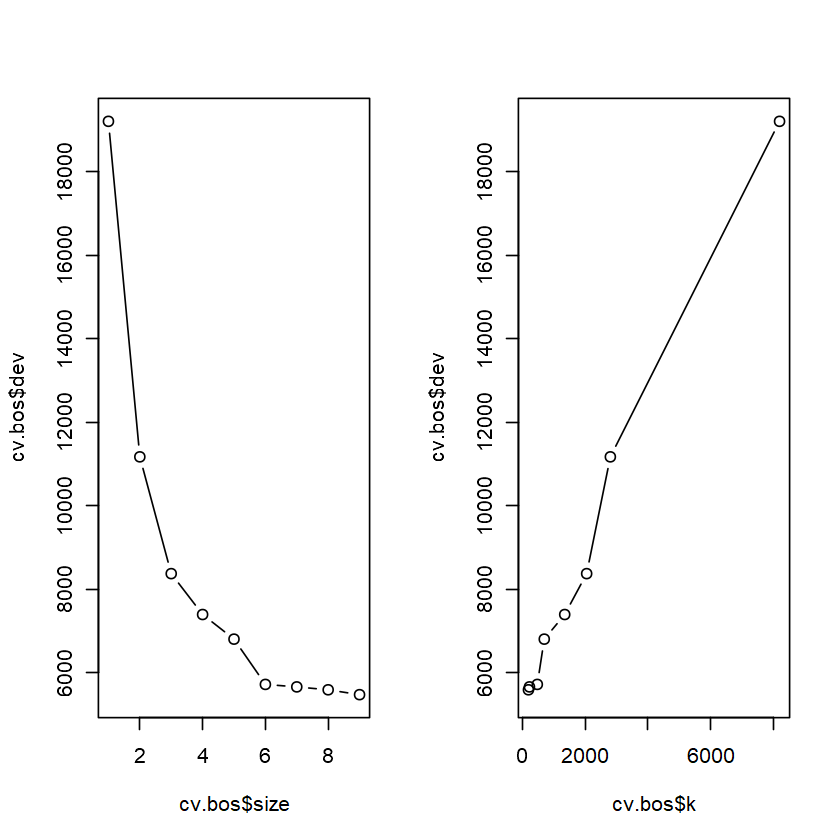

In [12]:
cv.bos <- cv.tree(rbigtree.bos)
cv.bos
cat("The size of best subtree is", cv.bos$size[which.min(cv.bos$dev)])
par(mfrow = c(1, 2))
plot(cv.bos$size, cv.bos$dev, type = "b")
plot(cv.bos$k, cv.bos$dev, type = "b")
cat("\nk which means alpha in prune algorithm")

prune---getting best subtree and predicting

The MSE for the best tree is 28.35633
The best subtree is the same as big tree

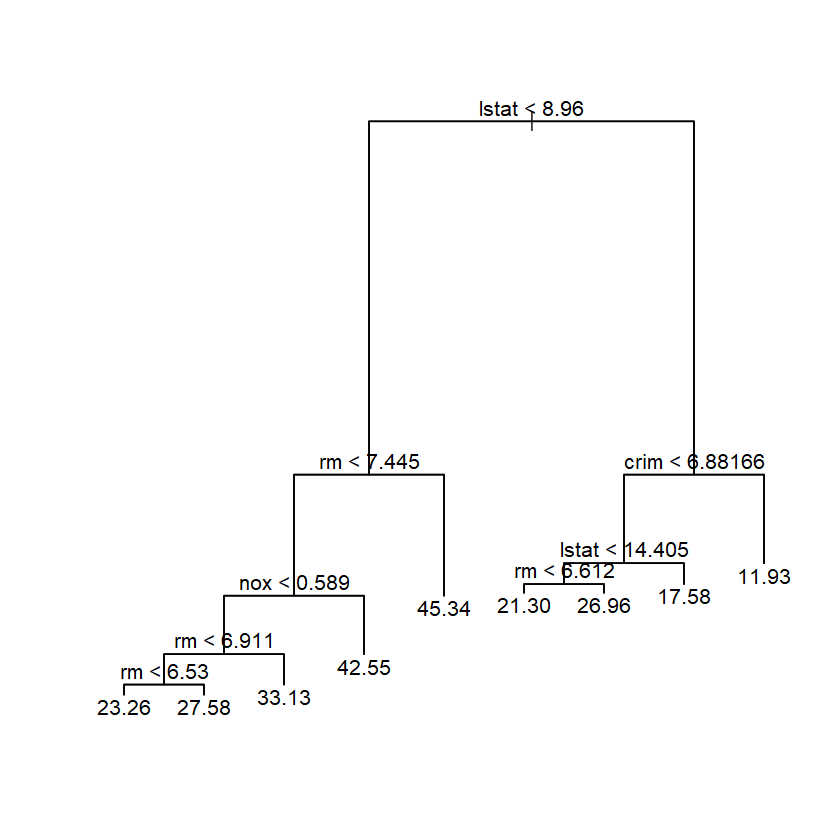

In [13]:
prune.bos <- prune.tree(tree = rbigtree.bos, best = cv.bos$size[which.min(cv.bos$dev)])
plot(prune.bos)
text(prune.bos, pretty = 0)
prune.pred <- predict(prune.bos, newdata = Boston[rtest, ])
cat("The MSE for the best tree is", mean((prune.pred - bos.test)^2))
cat("\nThe best subtree is the same as big tree")

## 2.2 Bagging and Random Forests
By default, randomForest()
uses p/3 variables when building a random forest of regression trees, and
$\sqrt{p}$ variables when building a random forest of classification trees.

bagging

In [14]:
set.seed(1)
rbag.bos <- randomForest(medv~., data = Boston[rtrain, ], mtry = 13, importance = TRUE)
rbag.bos
rbag.bos.pred <- predict(rbag.bos, newdata = Boston[rtest, ])
cat("Bagging with 500 trees' MSE is", mean((rbag.bos.pred - bos.test)^2))
rbag.bos.25trees <- randomForest(medv~., data = Boston[rtrain, ], mtry = 13, importance = TRUE, ntree = 25)
rbag.pred.25trees <- predict(rbag.bos.25trees, newdata = Boston[rtest, ])
cat("\nBagging with 25 trees's MSE is", mean((rbag.pred.25trees - bos.test)^2))


Call:
 randomForest(formula = medv ~ ., data = Boston[rtrain, ], mtry = 13,      importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 13

          Mean of squared residuals: 13.67381
                    % Var explained: 82.67

Bagging with 500 trees' MSE is 12.91285
Bagging with 25 trees's MSE is 13.97516

random forests


Call:
 randomForest(formula = medv ~ ., data = Boston[rtrain, ], mtry = 6,      importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 6

          Mean of squared residuals: 13.86539
                    % Var explained: 82.43

MSE:  12.44017

,%IncMSE,IncNodePurity
crim,14.4333267,1529.95829
zn,0.2323955,41.57220
indus,6.6057491,674.34736
chas,2.5136089,145.68452
nox,12.7918490,1057.53674
rm,31.1833156,5626.14701
age,7.6078451,476.95398
dis,12.5450591,1139.02820
rad,3.1216355,91.11593
tax,8.3361478,451.03624


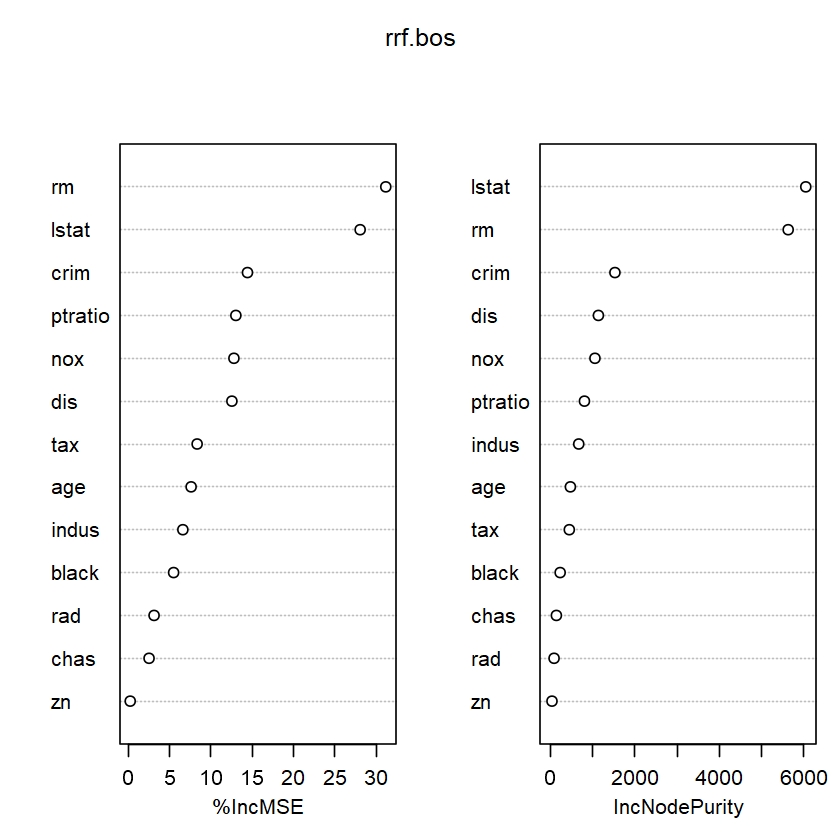

In [15]:
set.seed(1)
rrf.bos <- randomForest(medv~., data = Boston[rtrain, ], mtry = 6, importance = TRUE)
rrf.bos
rrf.pred <- predict(rrf.bos, newdata = Boston[rtest, ])
cat("MSE: ", mean((rrf.pred - bos.test)^2))
importance(rrf.bos)
varImpPlot(rrf.bos)

## 2.3 Boosting

fitting

In [16]:
set.seed(1)
rbost.bos <- gbm(medv~., data = Boston[rtrain, ], distribution = "gaussian",
    n.trees = 5000, interaction.depth = 4)
summary(rbost.bos, order = TRUE, plot = FALSE)
cat("'plot=FALSE' means that do not plot variables' importance histgram")

,var,rel.inf
,<chr>,<dbl>
lstat,lstat,39.4735138
rm,rm,25.0134417
dis,dis,10.5758611
crim,crim,6.0200632
black,black,4.6232783
ptratio,ptratio,3.7111780
nox,nox,3.4284599
age,age,3.0470228
tax,tax,1.7136523


'plot=FALSE' means that do not plot variables' importance histgram

We see that lstat and rm are by far the most important variables. We can
also produce $\textit{partial dependence plots}$ for these two variables. The partial dependence plot shows how the predicted outcome (or response variable) changes as a specific predictor variable of interest varies, while keeping all other predictors at fixed values.
Fixed value: this is typically done by setting them to their average values or representative values from the dataset.

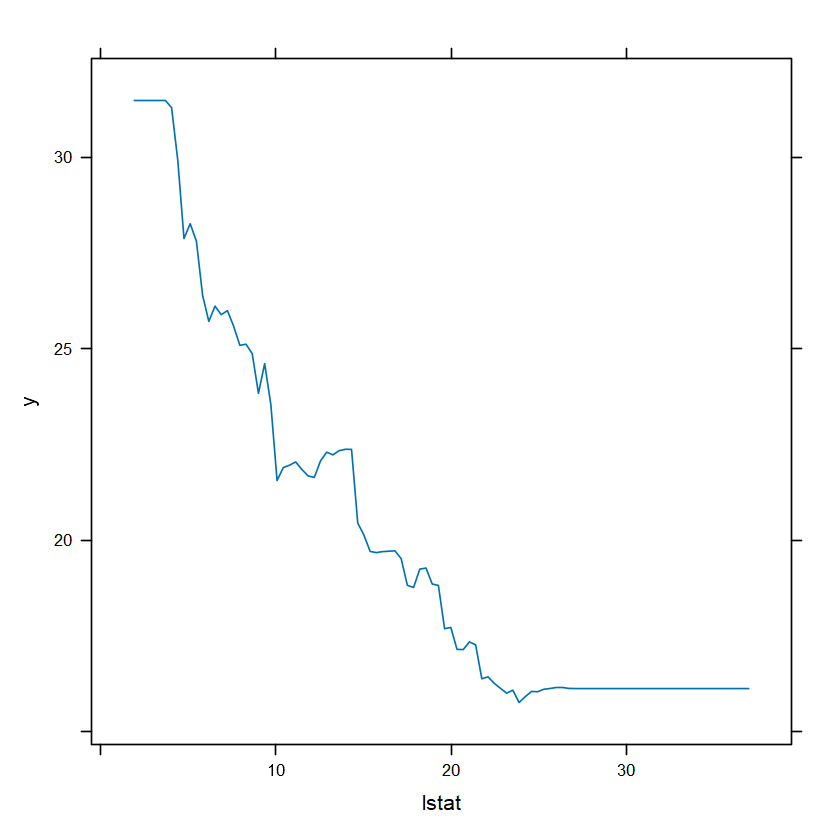

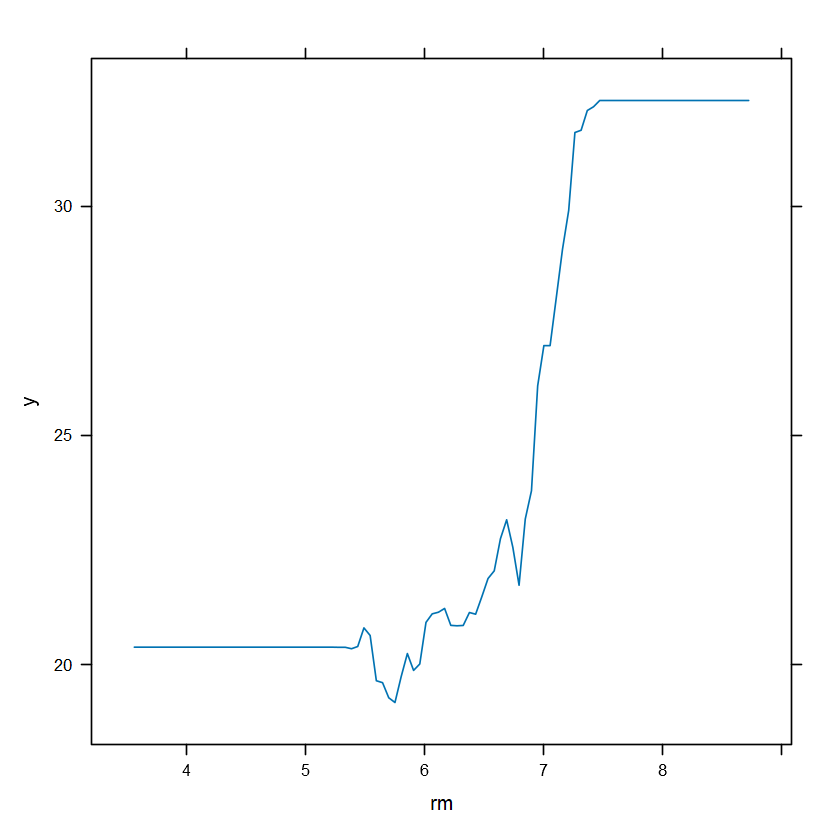

In [17]:
par(mfrow = c(1, 2))
plot(rbost.bos, i = "lstat")
plot(rbost.bos, i = "rm")

predicting

In [18]:
rbost.pred <- predict(rbost.bos, newdata = Boston[rtest, ], n.trees = 5000)
cat("The MSE is", mean((rbost.pred - bos.test)^2))

The MSE is 15.48319

changing the shrinkage rate

In [19]:
rbost.bos1 <- gbm(medv~., data = Boston[rtrain, ], distribution = "gaussian",
    n.trees = 5000, interaction.depth = 4, shrinkage = 0.2)
summary(rbost.bos1, plot = FALSE)
rbost.pred1 <- predict(rbost.bos1, newdata = Boston[rtest, ], n.trees = 5000)
cat("MSE:", mean((rbost.pred1 - bos.test)^2))

,var,rel.inf
,<chr>,<dbl>
lstat,lstat,41.3299700
rm,rm,19.4216419
dis,dis,8.8569749
crim,crim,8.4529934
nox,nox,6.5757069
black,black,4.8755617
ptratio,ptratio,3.0555001
age,age,2.5896471
tax,tax,1.9360822


MSE: 14.42013

# Save Environment

In [20]:
save.image("chapter8_TreeBasedMethods.RData")